## Import libraries  & loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/dslab"

/content/drive/MyDrive/dslab


In [ ]:
import re
import nltk
import string
import pandas as pd
nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset=pd.read_csv('labeled_data.csv')
dataset


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
dataset=pd.read_csv('labeled_data.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Data Analysis

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


Text(0, 0.5, 'Number of Tweets')

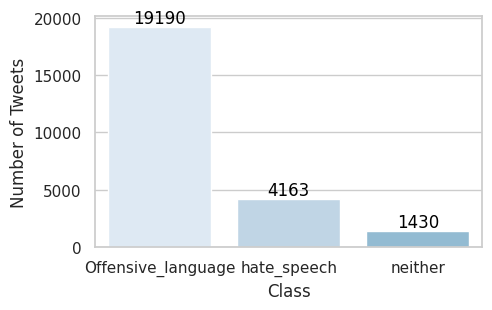

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
class_labels = ['Offensive_language', 'hate_speech', 'neither']
class_counts = dataset['class'].value_counts()
sns.set(style="whitegrid")
sns.set_palette("Blues")
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(x=class_labels, y=class_counts, ax=ax)
for bar, count in zip(ax.patches, class_counts):
    ax.annotate(f'{count}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom', color='black', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)


Number of Hate Speech Tweets: 19190

Number of Offensive Language Tweets: 4163

Number of Neither Tweets: 1430

In [ ]:
missing=dataset.isnull().sum()
print(missing)

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


 No null values





#Preprocessing

In [ ]:
tweet=dataset.tweet

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stopwords.remove('not')
stemmer = PorterStemmer()

def preprocess(tweet):

    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')

    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

     # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet

    return tweets_p

processed_tweets = preprocess(tweet)

dataset['processed_tweets'] = processed_tweets
print(dataset[["tweet","processed_tweets"]].head(10))

<ipython-input-64-3ec4e8c3210d>:24: FutureWarning: The default value of regex will change from True to False in a future version.
  punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
<ipython-input-64-3ec4e8c3210d>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=punc_remove.str.replace(r'\s+', ' ')
<ipython-input-64-3ec4e8c3210d>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
<ipython-input-64-3ec4e8c3210d>:30: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain clean hous amp man alway take t...  
1  boy dat cold tyga dwn bad cuffin dat hoe st place  
2         dawg ever fuck bitch start cri confus shit  
3                                   look like tranni  
4     shit hear might true might faker bitch told ya  
5      shit blow claim faith somebodi still fuck hoe 

In [ ]:
dataset.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
24778    False
24779    False
24780    False
24781    False
24782    False
Length: 24783, dtype: bool

In [ ]:
dt_transformed=dataset[['class','processed_tweets']]
y=dt_transformed.iloc[:,:-1].values

In [ ]:
print(dt_transformed)

       class                                   processed_tweets
0          2  woman complain clean hous amp man alway take t...
1          1  boy dat cold tyga dwn bad cuffin dat hoe st place
2          1         dawg ever fuck bitch start cri confus shit
3          1                                   look like tranni
4          1     shit hear might true might faker bitch told ya
...      ...                                                ...
24778      1  muthaf lie right hi tl trash mine bibl scriptu...
24779      2    gone broke wrong heart babi drove redneck crazi
24780      1  young buck wanna eat dat nigguh like aint fuck...
24781      1                     youu got wild bitch tellin lie
24782      2  ruffl ntac eileen dahlia beauti color combin p...

[24783 rows x 2 columns]


In [ ]:
print(y)

[[2]
 [1]
 [1]
 ...
 [1]
 [1]
 [2]]


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [ ]:
ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0])],remainder='passthrough')
y=np.array(ct.fit_transform(y))

In [ ]:
print(y)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
y_df=pd.DataFrame(y)
y_hate=np.array(y_df[0])
y_offensive=np.array(y_df[1])

In [ ]:
print(y_df)

         0    1    2
0      0.0  0.0  1.0
1      0.0  1.0  0.0
2      0.0  1.0  0.0
3      0.0  1.0  0.0
4      0.0  1.0  0.0
...    ...  ...  ...
24778  0.0  1.0  0.0
24779  0.0  0.0  1.0
24780  0.0  1.0  0.0
24781  0.0  1.0  0.0
24782  0.0  0.0  1.0

[24783 rows x 3 columns]


In [ ]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<24783x6689 sparse matrix of type '<class 'numpy.float64'>'
	with 199550 stored elements in Compressed Sparse Row format>

In [ ]:
from pandas.core.frame import DataFrame
p=DataFrame(tfidf)

In [ ]:
p.head()

,0
0,"(0, 5671)\t0.4309517500614609\n (0, 6008)\t..."
1,"(0, 1477)\t0.35408569797294004\n (0, 4505)\..."
2,"(0, 748)\t0.4047434652361727\n (0, 2142)\t0..."
3,"(0, 3466)\t0.6524605586008377\n (0, 3579)\t..."
4,"(0, 775)\t0.42764555354525047\n (0, 6586)\t..."


In [ ]:
print

<function print>

In [ ]:
X = tfidf
y = dataset['class'].astype(int)



In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

X_res, y_res = sm.fit_resample(X,y)


In [ ]:
print("class 0 : {}".format(sum(y_res== 0)))
print("class 1 : {}".format(sum(y_res== 1)))
print("class 2 : {}".format(sum(y_res== 2)))

class 0 : 19190
class 1 : 19190
class 2 : 19190


#model building

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [ ]:
support =LinearSVC(random_state=20)
support.fit(X_train,y_train)


LinearSVC(random_state=20)

In [ ]:
y_preds = support.predict(X_test)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , (acc3)*100)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3849
           1       0.98      0.87      0.92      3794
           2       0.90      0.98      0.94      3871

    accuracy                           0.92     11514
   macro avg       0.93      0.92      0.92     11514
weighted avg       0.93      0.92      0.92     11514

SVM, Accuracy Score: 92.41792600312662


In [ ]:
import pickle

In [ ]:
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

NameError: ignored

In [ ]:
# Save the trained SVM model to a .pkl file
with open('svm_model.pkl', 'wb') as model_file:
    pickle.dump(support, model_file)


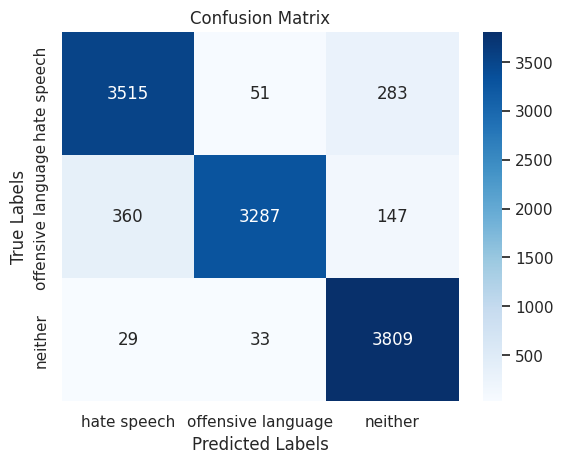

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_preds)

# Create a heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["hate speech", "offensive language", "neither"], yticklabels=["hate speech", "offensive language", "neither"])

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Display the plot
plt.show()


In [ ]:
np_score = accuracy_score(y_test, y_pred)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3849
           1       0.98      0.87      0.92      3794
           2       0.90      0.98      0.94      3871

    accuracy                           0.92     11514
   macro avg       0.92      0.92      0.92     11514
weighted avg       0.92      0.92      0.92     11514



In [ ]:
print('Accuracy: ', str(np_score))

Accuracy:  0.9215737363210005


In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import re
import nltk

# Sample input text
sample =" @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run"

# Preprocess the input text
def preprocess_input_text(sample):
    stemmer = PorterStemmer()

    # Define the list of extended stopwords
    extended_stopwords = nltk.corpus.stopwords.words("english")
    other_exclusions = ["#ff", "ff", "rt"]
    extended_stopwords.extend(other_exclusions)

    # Preprocessing steps
    # Step 1: Removal of extra spaces
    tweet_space = re.sub(r'\s+', ' ', sample)

    # Step 2: Removal of @name[mention]
    tweet_name = re.sub(r'@[\w\-]+', '', tweet_space)

    # Step 3: Removal of links [https://abc.com]
    tweet_no_links = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet_name)

    # Step 4: Removal of punctuations and numbers
    tweet_no_punctuation = re.sub("[^a-zA-Z]", " ", tweet_no_links)

    # Step 5: Remove leading and trailing whitespace
    tweet_stripped = tweet_no_punctuation.strip()

    # Step 6: Replace normal numbers with 'numbr'
    tweet_no_numbers = re.sub(r'\d+(\.\d+)?', 'numbr', tweet_stripped)

    # Step 7: Convert to lowercase
    tweet_lower = tweet_no_numbers.lower()

    # Step 8: Tokenize
    tokenized_tweet = tweet_lower.split()

    # Step 9: Remove stopwords and stem the tokens
    tokenized_tweet = [stemmer.stem(token) for token in tokenized_tweet if token not in extended_stopwords]

    # Step 10: Join the tokens back into a string
    processed_input_text = ' '.join(tokenized_tweet)

    return processed_input_text

# Preprocess the input text
processed_input_text = preprocess_input_text(sample)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75, min_df=5, max_features=10000)

# Fit the TF-IDF vectorizer on your dataset
tfidf = tfidf_vectorizer.fit_transform(processed_tweets)  # Assuming processed_tweets is your preprocessed dataset

# Transform the processed input text
tfidf_sample = tfidf_vectorizer.transform([processed_input_text])

# Make predictions
predicted_label = support.predict(tfidf_sample)[0]
# Map class labels to their meanings
class_labels = {
    0: "Hate Speech",
    1: "Offensive",
    2: "Neither"
}

# Get the label for the predicted class
predicted_label_text = class_labels[predicted_label]

# Print the result
print("Input Text:", sample)
print("Predicted Label:", predicted_label_text)


Input Text:  @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Predicted Label: Offensive


In [ ]:
document_id =0
tfidf_values_for_document = tfidf[document_id]


In [ ]:
tfidf_values_for_document

<1x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_values = tfidf_values_for_document.data  # TF-IDF values
term_indices = tfidf_values_for_document.indices

In [ ]:
tfidf_values

array([0.43095175, 0.2129236 , 0.26947253, 0.28485043, 0.25000764,
       0.22951771, 0.32473278, 0.37180373, 0.37805334, 0.33673876])

In [ ]:
term_indices

array([5549, 5823, 5536,  103, 3639,  124, 2896, 1189, 1266, 6262],
      dtype=int32)

In [ ]:
idf_values = tfidf_vectorizer.idf_


In [ ]:
idf_values

array([8.92072899, 9.17204341, 8.81536847, ..., 8.92072899, 8.02691111,
       9.32619409])